# **Anomaly Detection of Fraudulent Transactions**

*This notebook focuses on anomaly detection of fraudulent transactions. It starts with data loading and exploration, including handling missing values and visualizing distributions of transaction types, locations, and devices. Feature engineering is performed by creating user-based, time-based, and location-based features. Feature selection is done using correlation and variance thresholds. The data is then preprocessed using one-hot encoding and scaling. Hyperparameter tuning for an Isolation Forest model is performed, and the model is trained and used to predict anomalies. Finally, DBSCAN is used to identify anomalies, and the intersection of anomalies from both models is found. SHAP values are used to interpret the model's predictions and provide natural language explanations for individual anomalous transactions.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/parsed_data.csv")

In [ ]:
df.head()

,timestamp,user_id,txn_amount,txn_type,location,device
0,2025-07-15 12:56:05,user1076,4821.85,cashout,Glasgow,Pixel 6
1,2025-07-20 05:38:14,user1034,2191.06,top-up,NaN,iPhone 13
2,2025-06-13 10:04:51,user1068,1691.09,deposit,Glasgow,NaN
3,2025-07-29 23:47:37,user1014,3539.50,deposit,Glasgow,iPhone 13
4,2025-06-23 14:45:58,user1075,1215.74,debit,Leeds,Samsung Galaxy S10


In [ ]:
df.shape

(7773, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7773 entries, 0 to 7772
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   7773 non-null   object 
 1   user_id     7773 non-null   object 
 2   txn_amount  7773 non-null   float64
 3   txn_type    7773 non-null   object 
 4   location    6805 non-null   object 
 5   device      6692 non-null   object 
dtypes: float64(1), object(5)
memory usage: 364.5+ KB


In [ ]:
df.fillna("None", inplace=True)

In [ ]:
df.isna().sum()

,0
timestamp,0
user_id,0
txn_amount,0
txn_type,0
location,0
device,0


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].dtype

dtype('<M8[ns]')

In [ ]:
df['timestamp']

,timestamp
0,2025-07-15 12:56:05
1,2025-07-20 05:38:14
2,2025-06-13 10:04:51
3,2025-07-29 23:47:37
4,2025-06-23 14:45:58
...,...
7768,2025-06-10 03:55:41
7769,2025-07-08 08:50:09
7770,2025-07-31 07:41:34
7771,2025-06-23 05:14:03


In [ ]:
df['user_id'].value_counts()

,count
user_id,
user1020,238
user1081,198
user1087,190
user1027,180
user1048,180
...,...
user1072,32
user1026,32
user1044,32


Only 86 different people?

In [ ]:
len(df['user_id'].unique())

86

<Axes: >

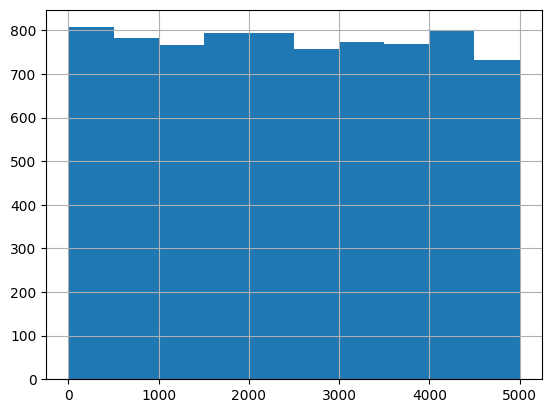

In [ ]:
df['txn_amount'].hist()

The transaction type seems to be fairly uniformly distributed. All the bars (bins) have roughly the same height, meaning that there is a similar number of data points in each interval along the x-axis.

In [ ]:
df['txn_amount'].describe()

,txn_amount
count,7773.000000
mean,2479.116813
std,1441.104108
min,1.620000
25%,1231.510000
50%,2464.070000
75%,3741.320000
max,4998.250000


The transaction amounts range from 1.62 to a maximum of 4998.25. The mean value of 2479.12 is very close to the median 2464.07, which indicates a symmetric distribution of the data. This is further supported by the 25th percentile (1231.51) and 75th percentile (3741.32) being roughly equidistant from the median. The standard deviation of 1441.10 suggests a wide spread of data points across the range. These suggest the data is fairly uniform as noticed from the histogram.

In [ ]:
txn_counts = df['txn_type'].value_counts()
txn_counts

,count
txn_type,
cashout,1015
debit,1007
deposit,991
top-up,987
withdrawal,970
transfer,958
purchase,940
refund,905


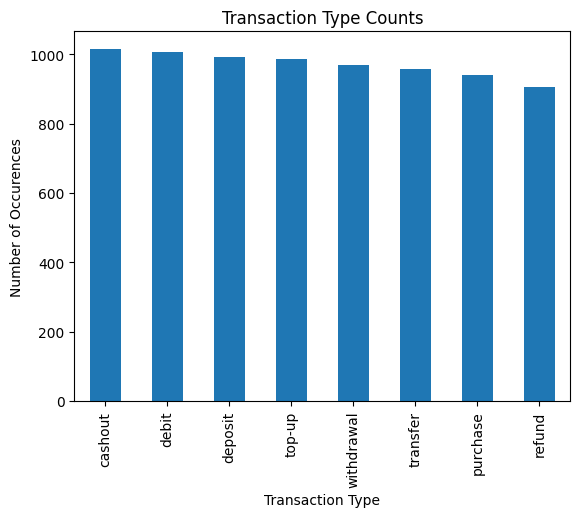

In [ ]:
txn_counts.plot(kind='bar', title='Transaction Type Counts')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Occurences')
plt.show()

Cashouts are the most popular type of transactions then debits. The least popular is refund

In [ ]:
location_counts = df['location'].value_counts()
location_counts

,count
location,
Leeds,995
London,983
Glasgow,979
Manchester,977
None,968
Birmingham,961
Cardiff,959
Liverpool,951


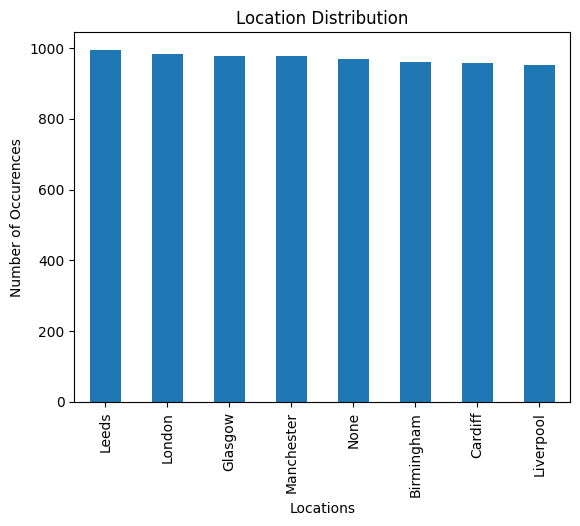

In [ ]:
location_counts.plot(kind='bar', title='Location Distribution')
plt.xlabel('Locations')
plt.ylabel('Number of Occurences')
plt.show()

Leeds is the most popular location while Liverpool is the least

In [ ]:
device_count = df['device'].value_counts()
device_count

,count
device,
Xiaomi Mi 11,1140
Samsung Galaxy S10,1133
iPhone 13,1130
Nokia 3310,1108
Pixel 6,1101
None,1081
Huawei P30,1080


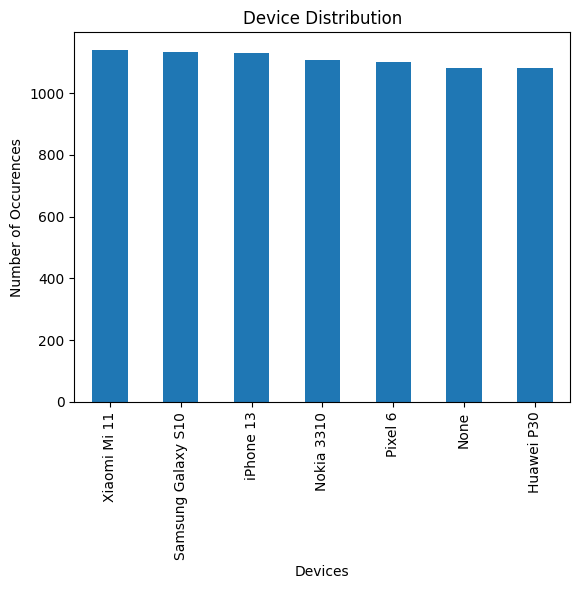

In [ ]:
device_count.plot(kind='bar', title='Device Distribution')
plt.xlabel('Devices')
plt.ylabel('Number of Occurences')
plt.show()

Xiaomi Mi 11 is the most popular device in the dataset and Huawei P30 is the least

## **Feature Engineering**

### **User-based Features**

In [ ]:
grouped_user_data = df.groupby('user_id')

In [ ]:
average_transaction_amount = grouped_user_data['txn_amount'].mean()
std_transaction_amount = grouped_user_data['txn_amount'].std()
max_transaction_amount = grouped_user_data['txn_amount'].max()
device_count = grouped_user_data['device'].nunique()
location_count = grouped_user_data['location'].nunique()

def calculate_entropy(series):
    """Calculates the entropy of a pandas Series."""
    value_counts = series.value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log(value_counts))
    return entropy

transaction_type_entropy = grouped_user_data['txn_type'].apply(calculate_entropy)

In [ ]:
user_features = pd.DataFrame(average_transaction_amount)
user_features.rename(columns={'txn_amount': 'avg_user_transaction_amount'}, inplace=True)
user_features['std_user_transaction_amount'] = std_transaction_amount
user_features['user_max_transaction_amount'] = max_transaction_amount
user_features['transaction_type_entropy'] = transaction_type_entropy
user_features['device_count'] = device_count
user_features['location_count'] = location_count
user_features.head()

,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,transaction_type_entropy,device_count,location_count
user_id,,,,,,
user1000,2488.370811,1498.974937,4859.83,2.010173,7,8
user1001,2088.694000,1614.517025,4677.14,1.844193,6,8
user1003,2612.899661,1472.269146,4944.93,2.038800,7,8
user1004,2457.218571,1469.607773,4987.69,2.041057,7,8
user1005,2376.596628,1350.958115,4977.03,2.051038,7,8


In [ ]:
user_features['location_count'].unique()

array([8])

In [ ]:
user_features['device_count'].unique()

array([7, 6])

<Axes: >

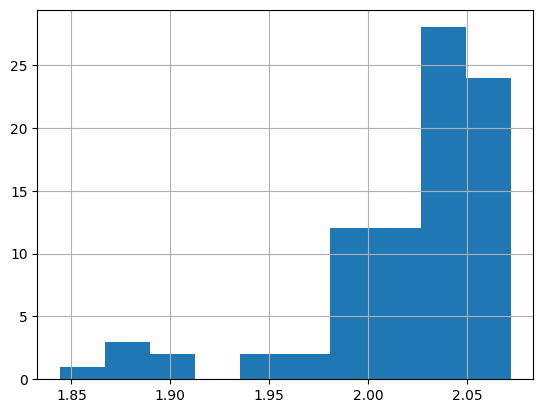

In [ ]:
user_features['transaction_type_entropy'].hist()

In [ ]:
user_features.drop(columns=['location_count','device_count'], inplace=True)

In [ ]:
user_features.columns

Index(['avg_user_transaction_amount', 'std_user_transaction_amount',
       'user_max_transaction_amount', 'transaction_type_entropy'],
      dtype='object')

In [ ]:
df = df.merge(user_features, on='user_id', how='left')

In [ ]:
df.head()

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,transaction_type_entropy
0,2025-07-15 12:56:05,user1076,4821.85,cashout,Glasgow,Pixel 6,2256.769672,1466.058311,4821.85,1.983320
1,2025-07-20 05:38:14,user1034,2191.06,top-up,None,iPhone 13,2573.211503,1334.642683,4945.12,2.059484
2,2025-06-13 10:04:51,user1068,1691.09,deposit,Glasgow,None,2442.362038,1410.889695,4997.29,2.069702
3,2025-07-29 23:47:37,user1014,3539.50,deposit,Glasgow,iPhone 13,2511.761697,1517.918083,4993.34,2.070909
4,2025-06-23 14:45:58,user1075,1215.74,debit,Leeds,Samsung Galaxy S10,2471.575000,1352.005147,4878.11,2.065512


In [ ]:
df.isnull().sum()

,0
timestamp,0
user_id,0
txn_amount,0
txn_type,0
location,0
device,0
avg_user_transaction_amount,0
std_user_transaction_amount,0
user_max_transaction_amount,0
transaction_type_entropy,0


### **Time-Based Features**

In [ ]:
df['hour_of_day'] = df['timestamp'].dt.hour
df['hour_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)
df[['hour_of_day', 'hour_of_day_sin', 'hour_of_day_cos', 'day_of_week', 'is_weekend']].head()

,hour_of_day,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend
0,12,1.224647e-16,-1.000000,1,0
1,5,9.659258e-01,0.258819,6,1
2,10,5.000000e-01,-0.866025,4,0
3,23,-2.588190e-01,0.965926,1,0
4,14,-5.000000e-01,-0.866025,0,0


In [ ]:
df['is_night'] = np.where((df['hour_of_day'] >= 21) | (df['hour_of_day'] <= 4), 1, 0)
df[['hour_of_day', 'is_night']].head()

,hour_of_day,is_night
0,12,0
1,5,0
2,10,0
3,23,1
4,14,0


In [ ]:
df.drop('hour_of_day', axis=1, inplace=True)

In [ ]:
df.sort_values(by=['user_id', 'timestamp'], inplace=True)
df.head()

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,transaction_type_entropy,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend,is_night
2131,2025-06-01 12:03:31,user1000,2981.21,cashout,London,Samsung Galaxy S10,2488.370811,1498.974937,4859.83,2.010173,1.224647e-16,-1.000000,6,1,0
3689,2025-06-01 19:19:50,user1000,1267.67,debit,Manchester,Xiaomi Mi 11,2488.370811,1498.974937,4859.83,2.010173,-9.659258e-01,0.258819,6,1,0
1146,2025-06-02 19:52:44,user1000,3610.68,refund,Cardiff,Huawei P30,2488.370811,1498.974937,4859.83,2.010173,-9.659258e-01,0.258819,0,0,0
4127,2025-06-03 10:11:53,user1000,4659.06,cashout,Birmingham,Nokia 3310,2488.370811,1498.974937,4859.83,2.010173,5.000000e-01,-0.866025,1,0,0
7175,2025-06-03 21:23:30,user1000,4063.97,cashout,Liverpool,None,2488.370811,1498.974937,4859.83,2.010173,-7.071068e-01,0.707107,1,0,1


In [ ]:
df['time_since_last_txn'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds()
df[['user_id', 'timestamp', 'time_since_last_txn']].head()

,user_id,timestamp,time_since_last_txn
2131,user1000,2025-06-01 12:03:31,NaN
3689,user1000,2025-06-01 19:19:50,26179.0
1146,user1000,2025-06-02 19:52:44,88374.0
4127,user1000,2025-06-03 10:11:53,51549.0
7175,user1000,2025-06-03 21:23:30,40297.0


In [ ]:
df.fillna({'time_since_last_txn':0}, inplace=True)

In [ ]:
txn_count_24hr_series = df.groupby('user_id').rolling('24h', on='timestamp')['timestamp'].count().reset_index(drop=True)
df['txn_count_24hr'] = txn_count_24hr_series
df[['user_id', 'timestamp', 'txn_count_24hr']].head()

,user_id,timestamp,txn_count_24hr
2131,user1000,2025-06-01 12:03:31,2.0
3689,user1000,2025-06-01 19:19:50,2.0
1146,user1000,2025-06-02 19:52:44,4.0
4127,user1000,2025-06-03 10:11:53,3.0
7175,user1000,2025-06-03 21:23:30,1.0


In [ ]:
df.shape

(7773, 17)

### **Location-Based Features**

In [ ]:
location_changes = df.groupby('user_id')['location'].apply(lambda x: (x != x.shift()).sum() - 1)
total_transactions = df.groupby('user_id').size()
location_change_freq = location_changes / total_transactions
location_change_freq = pd.DataFrame(location_change_freq, columns=['location_change_freq'])
location_change_freq.head()

,location_change_freq
user_id,
user1000,0.878378
user1001,0.857143
user1003,0.855932
user1004,0.761905
user1005,0.872093


In [ ]:
most_common_location = df.groupby('user_id')['location'].apply(lambda x: x.mode()[0])
most_common_location.head()

,location
user_id,
user1000,Birmingham
user1001,Cardiff
user1003,Liverpool
user1004,Manchester
user1005,Manchester


In [ ]:
df['is_new_location'] = df.groupby('user_id')['location'].transform(lambda x: (x != x.shift()).astype(int))
df[['user_id', 'timestamp', 'location', 'is_new_location']].head()

,user_id,timestamp,location,is_new_location
2131,user1000,2025-06-01 12:03:31,London,1
3689,user1000,2025-06-01 19:19:50,Manchester,1
1146,user1000,2025-06-02 19:52:44,Cardiff,1
4127,user1000,2025-06-03 10:11:53,Birmingham,1
7175,user1000,2025-06-03 21:23:30,Liverpool,1


In [ ]:
df = df.merge(location_change_freq, on='user_id', how='left')
df = df.merge(most_common_location.rename('most_common_location'), on='user_id', how='left')
df.head()

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,transaction_type_entropy,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend,is_night,time_since_last_txn,txn_count_24hr,is_new_location,location_change_freq,most_common_location
0,2025-06-01 12:03:31,user1000,2981.21,cashout,London,Samsung Galaxy S10,2488.370811,1498.974937,4859.83,2.010173,1.224647e-16,-1.000000,6,1,0,0.0,2.0,1,0.878378,Birmingham
1,2025-06-01 19:19:50,user1000,1267.67,debit,Manchester,Xiaomi Mi 11,2488.370811,1498.974937,4859.83,2.010173,-9.659258e-01,0.258819,6,1,0,26179.0,2.0,1,0.878378,Birmingham
2,2025-06-02 19:52:44,user1000,3610.68,refund,Cardiff,Huawei P30,2488.370811,1498.974937,4859.83,2.010173,-9.659258e-01,0.258819,0,0,0,88374.0,4.0,1,0.878378,Birmingham
3,2025-06-03 10:11:53,user1000,4659.06,cashout,Birmingham,Nokia 3310,2488.370811,1498.974937,4859.83,2.010173,5.000000e-01,-0.866025,1,0,0,51549.0,3.0,1,0.878378,Birmingham
4,2025-06-03 21:23:30,user1000,4063.97,cashout,Liverpool,None,2488.370811,1498.974937,4859.83,2.010173,-7.071068e-01,0.707107,1,0,1,40297.0,1.0,1,0.878378,Birmingham


In [ ]:
df.shape

(7773, 20)

In [ ]:
df['amount_zscore'] = df.groupby('user_id')['txn_amount'].transform(lambda x: (x - x.mean()) / x.std())
df[['user_id', 'txn_amount', 'amount_zscore']].head()

,user_id,txn_amount,amount_zscore
0,user1000,2981.21,0.328784
1,user1000,1267.67,-0.814357
2,user1000,3610.68,0.748718
3,user1000,4659.06,1.448116
4,user1000,4063.97,1.051118


In [ ]:
df['amount_to_avg_ratio'] = df['txn_amount'] / df['avg_user_transaction_amount']
df[['user_id', 'txn_amount', 'avg_user_transaction_amount', 'amount_to_avg_ratio']].head()

,user_id,txn_amount,avg_user_transaction_amount,amount_to_avg_ratio
0,user1000,2981.21,2488.370811,1.198057
1,user1000,1267.67,2488.370811,0.509438
2,user1000,3610.68,2488.370811,1.451022
3,user1000,4659.06,2488.370811,1.872333
4,user1000,4063.97,2488.370811,1.633185


In [ ]:
df['geo_device_mismatch'] = df.groupby('user_id')[['location', 'device']].apply(lambda x: (x['location'] != x['location'].shift()) & (x['device'] != x['device'].shift())).astype(int).reset_index(level=0, drop=True)
df[['user_id', 'timestamp', 'location', 'device', 'geo_device_mismatch']].head()

,user_id,timestamp,location,device,geo_device_mismatch
0,user1000,2025-06-01 12:03:31,London,Samsung Galaxy S10,1
1,user1000,2025-06-01 19:19:50,Manchester,Xiaomi Mi 11,1
2,user1000,2025-06-02 19:52:44,Cardiff,Huawei P30,1
3,user1000,2025-06-03 10:11:53,Birmingham,Nokia 3310,1
4,user1000,2025-06-03 21:23:30,Liverpool,None,1


In [ ]:
df.head()

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,transaction_type_entropy,...,is_weekend,is_night,time_since_last_txn,txn_count_24hr,is_new_location,location_change_freq,most_common_location,amount_zscore,amount_to_avg_ratio,geo_device_mismatch
0,2025-06-01 12:03:31,user1000,2981.21,cashout,London,Samsung Galaxy S10,2488.370811,1498.974937,4859.83,2.010173,...,1,0,0.0,2.0,1,0.878378,Birmingham,0.328784,1.198057,1
1,2025-06-01 19:19:50,user1000,1267.67,debit,Manchester,Xiaomi Mi 11,2488.370811,1498.974937,4859.83,2.010173,...,1,0,26179.0,2.0,1,0.878378,Birmingham,-0.814357,0.509438,1
2,2025-06-02 19:52:44,user1000,3610.68,refund,Cardiff,Huawei P30,2488.370811,1498.974937,4859.83,2.010173,...,0,0,88374.0,4.0,1,0.878378,Birmingham,0.748718,1.451022,1
3,2025-06-03 10:11:53,user1000,4659.06,cashout,Birmingham,Nokia 3310,2488.370811,1498.974937,4859.83,2.010173,...,0,0,51549.0,3.0,1,0.878378,Birmingham,1.448116,1.872333,1
4,2025-06-03 21:23:30,user1000,4063.97,cashout,Liverpool,None,2488.370811,1498.974937,4859.83,2.010173,...,0,1,40297.0,1.0,1,0.878378,Birmingham,1.051118,1.633185,1


In [ ]:
df.columns

Index(['timestamp', 'user_id', 'txn_amount', 'txn_type', 'location', 'device',
       'avg_user_transaction_amount', 'std_user_transaction_amount',
       'user_max_transaction_amount', 'transaction_type_entropy',
       'hour_of_day_sin', 'hour_of_day_cos', 'day_of_week', 'is_weekend',
       'is_night', 'time_since_last_txn', 'txn_count_24hr', 'is_new_location',
       'location_change_freq', 'most_common_location', 'amount_zscore',
       'amount_to_avg_ratio', 'geo_device_mismatch'],
      dtype='object')

In [ ]:
df['geo_device_mismatch'].value_counts()

,count
geo_device_mismatch,
1,5887
0,1886


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7773 entries, 0 to 7772
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   timestamp                    7773 non-null   datetime64[ns]
 1   user_id                      7773 non-null   object        
 2   txn_amount                   7773 non-null   float64       
 3   txn_type                     7773 non-null   object        
 4   location                     7773 non-null   object        
 5   device                       7773 non-null   object        
 6   avg_user_transaction_amount  7773 non-null   float64       
 7   std_user_transaction_amount  7773 non-null   float64       
 8   user_max_transaction_amount  7773 non-null   float64       
 9   transaction_type_entropy     7773 non-null   float64       
 10  hour_of_day_sin              7773 non-null   float64       
 11  hour_of_day_cos              7773 non-null 

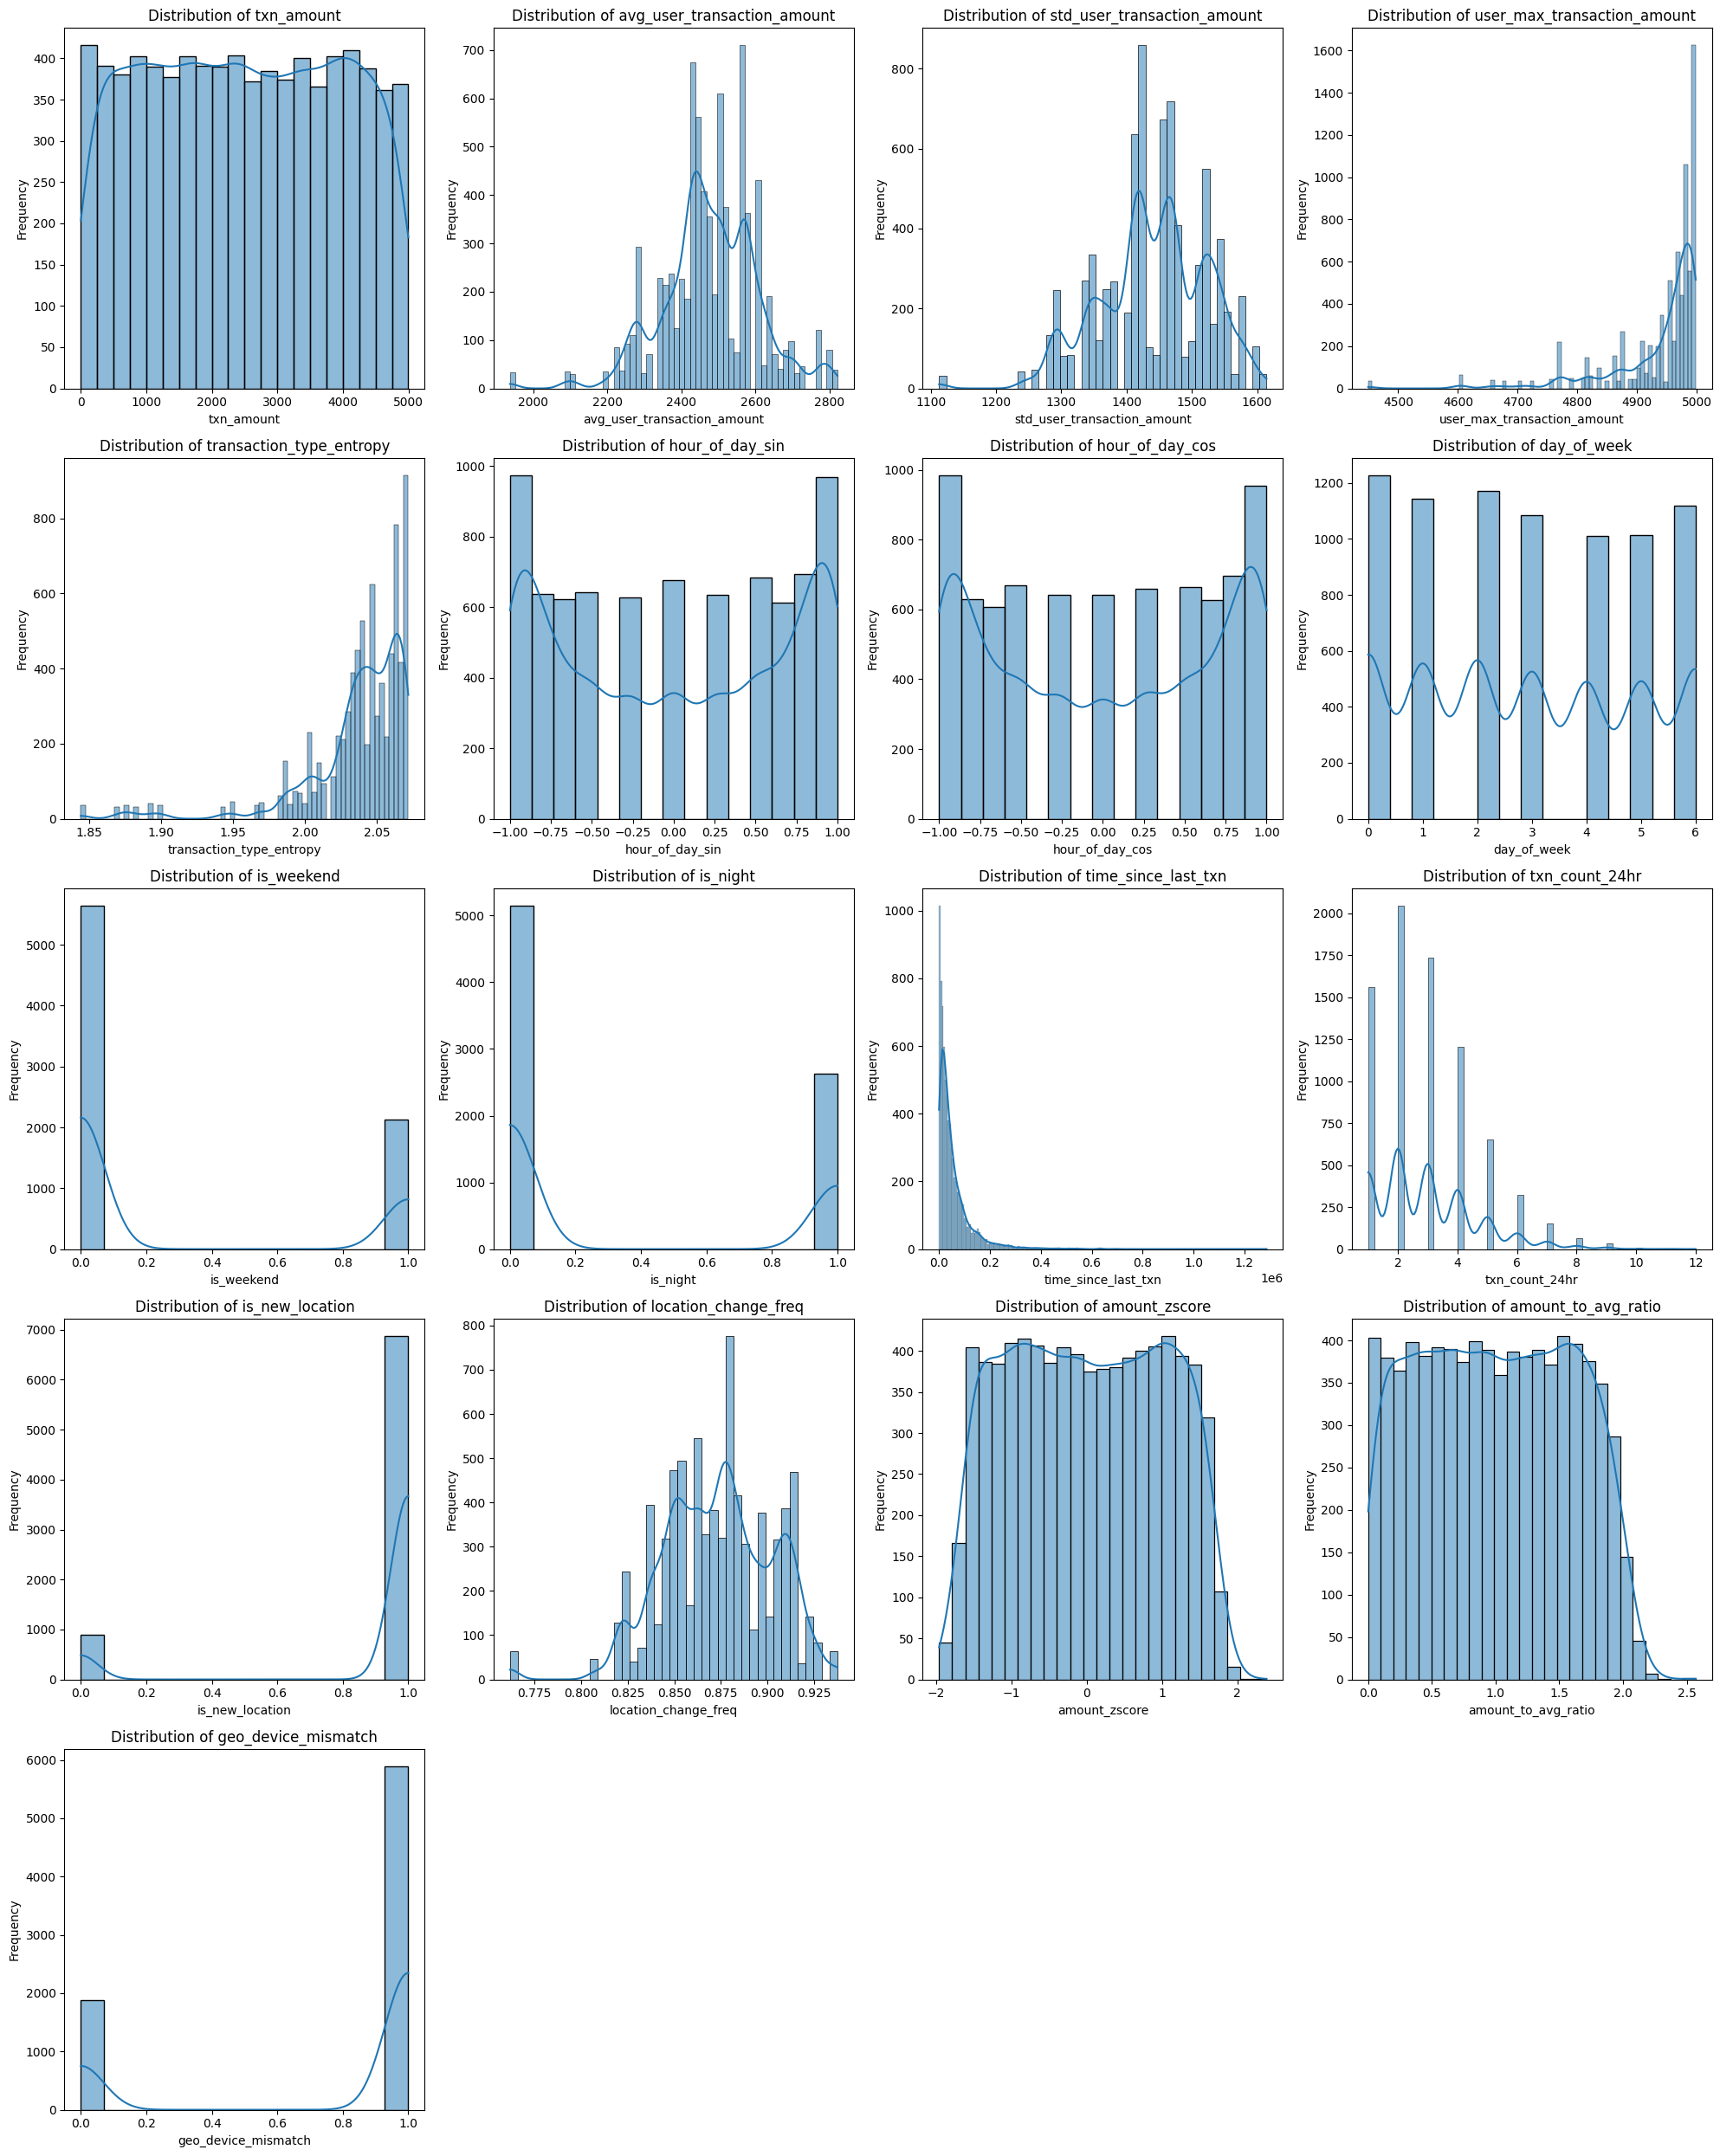

In [ ]:
numeric_vars = df.select_dtypes(include=np.number)
numeric_cols = numeric_vars.columns
n_cols = 4  # Number of columns for subplots
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols # Calculate the number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Analysis of Numeric Variable Distributions

Based on the generated histograms of the numeric variables:

- **`txn_amount`**: The distribution appears relatively uniform across the range of values.
- **`avg_user_transaction_amount`**: This distribution seems to be somewhat skewed to the right, with a peak around a certain average transaction amount and a tail extending towards higher values.
- **`std_user_transaction_amount`**: Similar to the average transaction amount, the standard deviation of transaction amounts also appears to be right-skewed.
- **`user_max_transaction_amount`**: The distribution of the maximum transaction amount per user shows a peak at lower values and a tail towards higher maximum amounts, indicating some users have significantly higher maximum transactions.
- **`transaction_type_entropy`**: The entropy of transaction types is concentrated around higher values, suggesting that most users engage in a diverse range of transaction types. There is a smaller peak at lower entropy values, indicating some users might have a less diverse set of transaction types.
- **`hour_of_day_sin` and `hour_of_day_cos`**: These show cyclical patterns as expected from the sine and cosine transformations of the hour of the day.
- **`day_of_week`**: The distribution of the day of the week appears relatively uniform across all days.
- **`is_weekend`**: This is a binary variable showing the count of transactions occurring on weekends (1) vs. weekdays (0). The distribution indicates there are more transactions on weekdays than weekends.
- **`is_night`**: This is a binary variable indicating transactions during nighttime hours. The distribution shows there are significantly fewer transactions during the defined nighttime hours compared to daytime hours.
- **`time_since_last_txn`**: This distribution is heavily skewed to the right, with a large number of transactions occurring shortly after the previous one and a long tail for longer time differences. This is typical for time-since-event features.
- **`txn_count_24hr`**: The number of transactions in the last 24 hours is also right-skewed, with most users having a smaller number of transactions within 24 hours and fewer users having a higher count.
- **`is_new_location`**: This binary variable shows that a significant number of transactions occur at a new location compared to the previous transaction.
- **`location_change_freq`**: The frequency of location changes appears to have multiple peaks and is not uniformly distributed, suggesting varying patterns of location changes among users.
- **`amount_zscore`**: The z-score of transaction amounts appears to be roughly normally distributed around zero, as expected after standardization within each user group.
- **`amount_to_avg_ratio`**: The ratio of transaction amount to the user's average transaction amount is right-skewed, indicating that some transactions are significantly larger than a user's typical transaction amount.
- **`geo_device_mismatch`**: This binary variable shows that there are more transactions where the location and device change simultaneously compared to transactions where they don't.

In [ ]:
df.dtypes

,0
timestamp,datetime64[ns]
user_id,object
txn_amount,float64
txn_type,object
location,object
device,object
avg_user_transaction_amount,float64
std_user_transaction_amount,float64
user_max_transaction_amount,float64
transaction_type_entropy,float64


### **Feature Selection**

<Figure size 1500x1000 with 0 Axes>

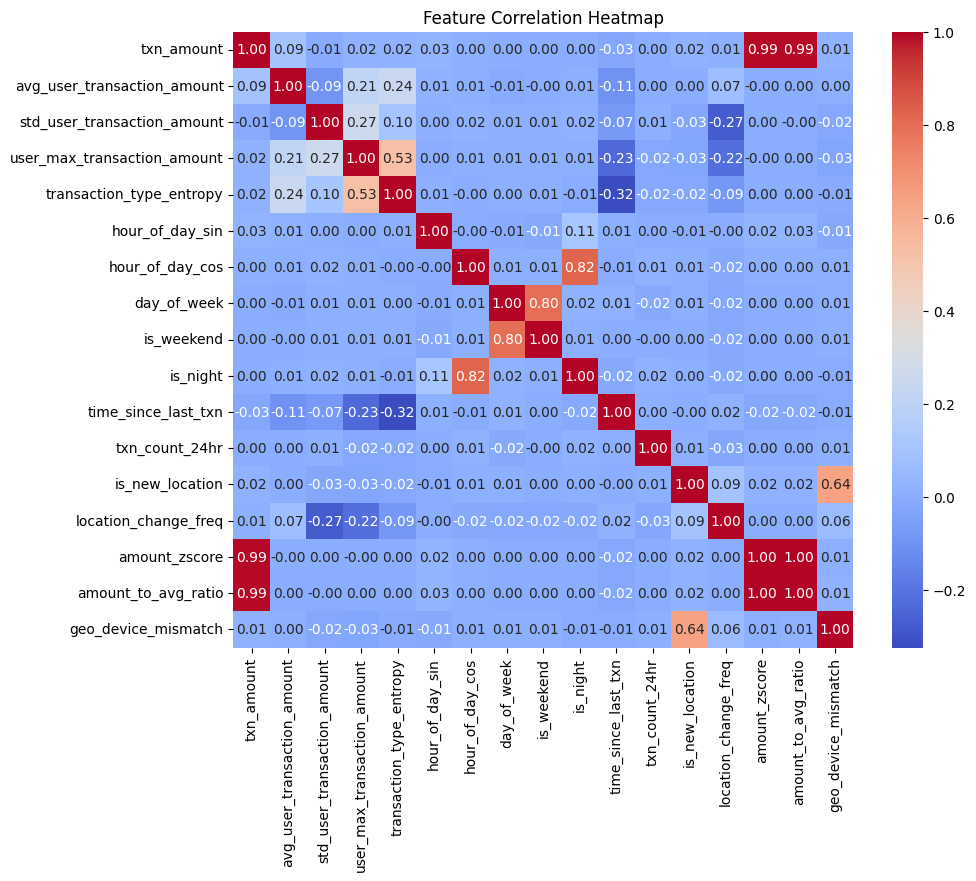

In [ ]:
plt.figure(figsize=(15, 10))
corr = numeric_vars.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

Amount Z score and Amount-to-average ratio are almost perfectly correlated so Amount-to-average ratio will be dropped.

In [ ]:
df.drop(columns=['amount_to_avg_ratio'], inplace=True)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(numeric_vars)

variances = selector.variances_

variance_df = pd.DataFrame({
    'feature': numeric_cols,
    'variance': variances
})

variance_df_sorted = variance_df.sort_values(by='variance')

# Show features below the threshold
low_variance_features = variance_df_sorted[variance_df_sorted['variance'] < 0.01]

print("Low variance features (below threshold):")
low_variance_features

Low variance features (below threshold):


,feature,variance
13,location_change_freq,0.000860
4,transaction_type_entropy,0.001346


In [ ]:
df.drop(columns=['location_change_freq','transaction_type_entropy'], inplace=True)

In [ ]:
df.columns

Index(['timestamp', 'user_id', 'txn_amount', 'txn_type', 'location', 'device',
       'avg_user_transaction_amount', 'std_user_transaction_amount',
       'user_max_transaction_amount', 'hour_of_day_sin', 'hour_of_day_cos',
       'day_of_week', 'is_weekend', 'is_night', 'time_since_last_txn',
       'txn_count_24hr', 'is_new_location', 'most_common_location',
       'amount_zscore', 'geo_device_mismatch'],
      dtype='object')

### **Preprocessing**

In [ ]:
X = df.drop(columns=['timestamp','user_id'])

In [ ]:
X.dtypes

,0
txn_amount,float64
txn_type,object
location,object
device,object
avg_user_transaction_amount,float64
std_user_transaction_amount,float64
user_max_transaction_amount,float64
hour_of_day_sin,float64
hour_of_day_cos,float64
day_of_week,int32


In [ ]:
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

In [ ]:
X_encoded.head()

,txn_amount,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend,is_night,time_since_last_txn,...,device_Xiaomi Mi 11,device_iPhone 13,most_common_location_Birmingham,most_common_location_Cardiff,most_common_location_Glasgow,most_common_location_Leeds,most_common_location_Liverpool,most_common_location_London,most_common_location_Manchester,most_common_location_None
0,2981.21,2488.370811,1498.974937,4859.83,1.224647e-16,-1.000000,6,1,0,0.0,...,False,False,True,False,False,False,False,False,False,False
1,1267.67,2488.370811,1498.974937,4859.83,-9.659258e-01,0.258819,6,1,0,26179.0,...,True,False,True,False,False,False,False,False,False,False
2,3610.68,2488.370811,1498.974937,4859.83,-9.659258e-01,0.258819,0,0,0,88374.0,...,False,False,True,False,False,False,False,False,False,False
3,4659.06,2488.370811,1498.974937,4859.83,5.000000e-01,-0.866025,1,0,0,51549.0,...,False,False,True,False,False,False,False,False,False,False
4,4063.97,2488.370811,1498.974937,4859.83,-7.071068e-01,0.707107,1,0,1,40297.0,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
X_encoded.shape

(7773, 45)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Define feature groups
standard_features = [
    'amount_zscore',
    'hour_of_day_sin',
    'hour_of_day_cos'
]

minmax_features = [
    'txn_amount',
    'day_of_week',
    'is_weekend',
    'is_night',
    'is_new_location',
    'geo_device_mismatch'
]

robust_features = [
    'avg_user_transaction_amount',
    'std_user_transaction_amount',
    'user_max_transaction_amount',
    'time_since_last_txn',
    'txn_count_24hr',
]

categorical_features = [
    col for col in X_encoded.columns
    if (
        col.startswith('device_')
        or col.startswith('txn_type_')
        or col.startswith('most_common_')
        or col.startswith('location_')
    )
]

# Build ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('std',   StandardScaler(), standard_features),
    ('mm',    MinMaxScaler(),  minmax_features),
    ('rob',   RobustScaler(),  robust_features),
    ('cat',   'passthrough',    categorical_features)
], remainder='drop')

X_scaled = preprocessor.fit_transform(X_encoded)

# Assemble back into DataFrame with proper column names
scaled_feature_names = standard_features + minmax_features + robust_features + categorical_features
X_scaled_df = pd.DataFrame(X_scaled, columns=scaled_feature_names)

In [ ]:
X_scaled_df

,amount_zscore,hour_of_day_sin,hour_of_day_cos,txn_amount,day_of_week,is_weekend,is_night,is_new_location,geo_device_mismatch,avg_user_transaction_amount,...,device_Xiaomi Mi 11,device_iPhone 13,most_common_location_Birmingham,most_common_location_Cardiff,most_common_location_Glasgow,most_common_location_Leeds,most_common_location_Liverpool,most_common_location_London,most_common_location_Manchester,most_common_location_None
0,0.330618,-0.010505,-1.422632,0.596320,1.000000,1.0,0.0,1.0,1.0,0.097024,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.818900,-1.376602,0.357674,0.253381,1.000000,1.0,0.0,1.0,1.0,0.097024,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.752894,-1.376602,0.357674,0.722299,0.000000,0.0,0.0,1.0,1.0,0.097024,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.456194,0.696639,-1.233156,0.932116,0.166667,0.0,0.0,1.0,1.0,0.097024,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.056981,-1.010557,0.991672,0.813018,0.166667,0.0,1.0,1.0,1.0,0.097024,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7768,-0.622190,-0.717649,-1.233156,0.283939,0.500000,0.0,0.0,0.0,0.0,-1.667409,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7769,0.479006,0.696639,-1.233156,0.569628,0.666667,0.0,0.0,1.0,1.0,-1.667409,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7770,0.500814,-1.424793,-0.008365,0.575286,0.666667,0.0,0.0,1.0,1.0,-1.667409,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7771,-0.715386,0.355540,-1.374442,0.259761,1.000000,1.0,0.0,1.0,0.0,-1.667409,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_scaled_df.shape

(7773, 45)

### **Hyperparameter Tuning**

In [ ]:
from sklearn.ensemble import IsolationForest

results = []

for n in [100, 200]:
    for max_samp in [128, 256]:
        for cont in [0.01, 0.02]:
            clf = IsolationForest(
                n_estimators=n,
                max_samples=max_samp,
                contamination=cont,
                random_state=42,
                n_jobs=-1
            )
            clf.fit(X_scaled)

            scores = clf.decision_function(X_scaled)
            anomalies = clf.predict(X_scaled)  # -1 for anomalies

            top_anom_idx = np.argsort(scores)[:50]
            top_anomalies = df.iloc[top_anom_idx]  # original df

            results.append({
                'n_estimators': n,
                'max_samples': max_samp,
                'contamination': cont,
                'mean_score': np.mean(scores),
                'num_flagged': np.sum(anomalies == -1),
                'top_anomalies_preview': top_anomalies.head(3)
            })

pd.DataFrame(results)

,n_estimators,max_samples,contamination,mean_score,num_flagged,top_anomalies_preview
0,100,128,0.01,0.048310,78,timestamp user_id txn_amount...
1,100,128,0.02,0.042167,156,timestamp user_id txn_amount...
2,100,256,0.01,0.047168,78,timestamp user_id txn_amount...
3,100,256,0.02,0.039665,156,timestamp user_id txn_amount...
4,200,128,0.01,0.045846,78,timestamp user_id txn_amount...
5,200,128,0.02,0.039749,156,timestamp user_id txn_amount...
6,200,256,0.01,0.045168,78,timestamp user_id txn_amount...
7,200,256,0.02,0.039551,156,timestamp user_id txn_amount...


#### **Columns Explained**

| Column                  | Meaning                                                                                             |
| ----------------------- | --------------------------------------------------------------------------------------------------- |
| `n_estimators`          | Number of trees in the Isolation Forest. More trees = more stable results, but slower.              |
| `max_samples`           | Number of samples to draw for each tree. Lower values add randomness, higher may stabilize results. |
| `contamination`         | The proportion of expected anomalies (used to define the decision threshold).                       |
| `mean_score`            | The average anomaly score of the flagged anomalies (usually lower = more anomalous).                |
| `num_flagged`           | Number of anomalies the model flagged (based on contamination).                                     |
| `top_anomalies_preview` | Preview of data points identified as most anomalous.                                                |

---

#### **What the Output Tell Us**

I ran a grid search over:

* `n_estimators`: 100, 200
* `max_samples`: 128, 256
* `contamination`: 0.01, 0.02


Let's interpret the rows by comparing:

#### *Best anomaly separation (based on mean score):*

* **Row 0 (mean\_score: 0.0483)** is highest.

  * This config: `n_estimators=100`, `max_samples=128`, `contamination=0.01`
  * Flags only 78 anomalies (1% contamination)
  * This might be the most "precise" model — fewer anomalies, higher confidence.

#### *More anomalies, but lower mean score:*

* **Row 1, 3, 5, 7** use `contamination=0.02`, hence flag 156 anomalies.

  * But the average scores are **lower**, meaning the model is either less confident or more noisy.
  * This might help **recall** (finding more true anomalies), but risks more **false positives**.

#### *Higher n\_estimators:*

* Rows 4–7 use `n_estimators=200`. These have **slightly lower mean scores** than `n_estimators=100`, suggesting **diminishing returns** or overfitting/noise.


#### Decision

1. **Best for precision**: `n_estimators=100`, `max_samples=128`, `contamination=0.01`.
2. **Best for recall (more anomalies)**: `n_estimators=100`, `max_samples=128`, `contamination=0.02` — but flagged cases have to be reviewed.

I'll assume precision is more important to XXX at this point. If XXX optimized for high recall, the system would be designed to catch as many fraudulent transactions as possible. This sounds good, but it would inevitably lead to a high number of False Positives. This could lead to bad user experience and lack of trust in the system which would be bad for business

We can visualize the tradeoff below


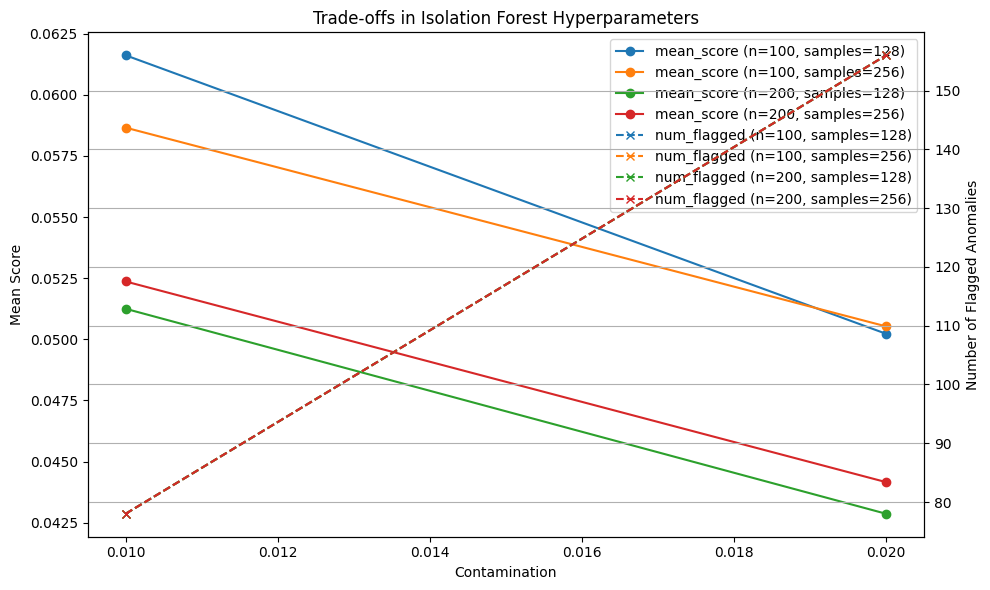

In [ ]:
# Define the data
data = {
    'n_estimators': [100, 100, 100, 100, 200, 200, 200, 200],
    'max_samples': [128, 128, 256, 256, 128, 128, 256, 256],
    'contamination': [0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02],
    'mean_score': [0.061620, 0.050227, 0.058660, 0.050530, 0.051252, 0.042866, 0.052369, 0.044160],
    'num_flagged': [78, 156, 78, 156, 78, 156, 78, 156],
}
data = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot each configuration line
for idx, ((n, s), group) in enumerate(data.groupby(['n_estimators', 'max_samples'])):
    group = group.sort_values('contamination')
    ax1.plot(group['contamination'], group['mean_score'],
             label=f'mean_score (n={n}, samples={s})',
             marker='o', color=colors[idx % len(colors)])

# Add second y-axis for number of flagged anomalies
ax2 = ax1.twinx()
for idx, ((n, s), group) in enumerate(data.groupby(['n_estimators', 'max_samples'])):
    group = group.sort_values('contamination')
    ax2.plot(group['contamination'], group['num_flagged'],
             label=f'num_flagged (n={n}, samples={s})',
             marker='x', linestyle='--', color=colors[idx % len(colors)])

# Labels and legends
ax1.set_xlabel('Contamination')
ax1.set_ylabel('Mean Score', color='black')
ax2.set_ylabel('Number of Flagged Anomalies', color='black')
ax1.set_title('Trade-offs in Isolation Forest Hyperparameters')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(results)['top_anomalies_preview'][0]

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend,is_night,time_since_last_txn,txn_count_24hr,is_new_location,most_common_location,amount_zscore,geo_device_mismatch
7734,2025-06-08 13:33:27,user1099,1170.08,debit,Liverpool,Samsung Galaxy S10,2226.905122,1303.531033,4654.78,-0.258819,-0.965926,6,1,0,398549.0,6.0,0,Birmingham,-0.810740,0
92,2025-06-30 08:43:40,user1001,3135.26,cashout,Birmingham,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,0.866025,-0.500000,0,0,0,156441.0,4.0,0,Cardiff,0.648222,0
5610,2025-07-26 01:20:59,user1074,4318.35,cashout,London,Samsung Galaxy S10,2797.934500,1487.906921,4983.85,0.258819,0.965926,5,1,1,1911.0,4.0,0,None,1.021849,0


In [ ]:
from sklearn.ensemble import IsolationForest

isf_model = IsolationForest(n_estimators=100, max_samples=128,contamination=0.01,random_state=42)
isf_model.fit(X_scaled_df)

IsolationForest(contamination=0.01, max_samples=128, random_state=42)

In [ ]:
# Predict anomaly scores
anomaly_scores = isf_model.decision_function(X_scaled_df)

anomaly_labels = isf_model.predict(X_scaled_df)

# Add anomaly scores and labels to the original DataFrame
df['anomaly_score'] = anomaly_scores
df['anomaly_label'] = anomaly_labels

df[['timestamp', 'user_id', 'txn_amount', 'anomaly_score', 'anomaly_label']].head()

,timestamp,user_id,txn_amount,anomaly_score,anomaly_label
0,2025-06-01 12:03:31,user1000,2981.21,0.066977,1
1,2025-06-01 19:19:50,user1000,1267.67,0.061108,1
2,2025-06-02 19:52:44,user1000,3610.68,0.060033,1
3,2025-06-03 10:11:53,user1000,4659.06,0.050436,1
4,2025-06-03 21:23:30,user1000,4063.97,0.043987,1


In [ ]:
df['anomaly_label'].value_counts()

,count
anomaly_label,
1,7695
-1,78


In [ ]:
anomalies_only = df[df['anomaly_label'] == -1]

# Sort by anomaly score (lowest = most abnormal)
ranked_anomalies = anomalies_only.sort_values('anomaly_score')

top_50_anomalies = ranked_anomalies.head(50)

In [ ]:
top_50_anomalies

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,hour_of_day_sin,...,is_weekend,is_night,time_since_last_txn,txn_count_24hr,is_new_location,most_common_location,amount_zscore,geo_device_mismatch,anomaly_score,anomaly_label
7734,2025-06-08 13:33:27,user1099,1170.08,debit,Liverpool,Samsung Galaxy S10,2226.905122,1303.531033,4654.78,-2.588190e-01,...,1,0,398549.0,6.0,0,Birmingham,-0.810740,0,-0.043413,-1
92,2025-06-30 08:43:40,user1001,3135.26,cashout,Birmingham,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,8.660254e-01,...,0,0,156441.0,4.0,0,Cardiff,0.648222,0,-0.023852,-1
5610,2025-07-26 01:20:59,user1074,4318.35,cashout,London,Samsung Galaxy S10,2797.934500,1487.906921,4983.85,2.588190e-01,...,1,1,1911.0,4.0,0,None,1.021849,0,-0.023046,-1
6785,2025-07-19 05:02:46,user1088,94.58,purchase,Liverpool,Huawei P30,2112.587931,1364.898147,4816.64,9.659258e-01,...,1,0,173658.0,4.0,1,Cardiff,-1.478504,0,-0.022534,-1
1270,2025-06-28 04:07:58,user1017,2093.98,transfer,Glasgow,Nokia 3310,2269.750721,1415.008029,4980.95,8.660254e-01,...,1,1,171986.0,1.0,0,None,-0.124219,0,-0.020178,-1
7051,2025-07-05 01:09:24,user1092,4994.05,deposit,Glasgow,Nokia 3310,2699.616837,1413.069765,4994.05,2.588190e-01,...,1,1,116469.0,3.0,0,London,1.623722,0,-0.018755,-1
1200,2025-07-16 08:13:25,user1015,697.21,deposit,Cardiff,Nokia 3310,2191.739714,1294.863502,4449.64,8.660254e-01,...,0,0,1286944.0,3.0,0,London,-1.154199,0,-0.018527,-1
1210,2025-07-19 21:11:23,user1015,1094.18,withdrawal,Cardiff,Nokia 3310,2191.739714,1294.863502,4449.64,-7.071068e-01,...,1,1,31335.0,3.0,1,London,-0.847626,0,-0.017469,-1
5579,2025-07-06 00:38:11,user1074,2475.15,purchase,Birmingham,Nokia 3310,2797.934500,1487.906921,4983.85,0.000000e+00,...,1,1,101158.0,1.0,0,None,-0.216939,0,-0.017005,-1
1272,2025-06-29 01:08:30,user1017,2619.87,debit,Glasgow,Huawei P30,2269.750721,1415.008029,4980.95,2.588190e-01,...,1,1,3892.0,5.0,0,None,0.247433,0,-0.016916,-1


In [ ]:
top_50_anomalies.to_csv('top_50_anomalies.csv')

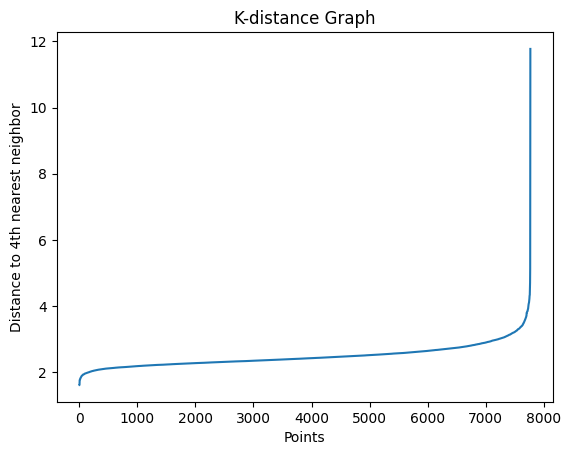

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot the distances to the 4th nearest neighbor
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance to 4th nearest neighbor')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3.0, min_samples=4)

# Fit DBSCAN on the data
dbscan_labels = dbscan.fit_predict(X_scaled)

np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
noise_count = np.count_nonzero(dbscan_labels == -1)

In [ ]:
noise_count

313

In [ ]:
df['anomaly_label_dbscan'] = dbscan_labels

# Filter for anomalies flagged by both models
anomalies_intersection = df[(df['anomaly_label'] == -1) & (df['anomaly_label_dbscan'] == -1)]

anomalies_intersection

,timestamp,user_id,txn_amount,txn_type,location,device,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,hour_of_day_sin,...,is_night,time_since_last_txn,txn_count_24hr,is_new_location,most_common_location,amount_zscore,geo_device_mismatch,anomaly_score,anomaly_label,anomaly_label_dbscan
75,2025-06-04 20:07:17,user1001,761.79,transfer,Glasgow,None,2088.694000,1614.517025,4677.14,-8.660254e-01,...,0,277296.0,4.0,1,Cardiff,-0.821858,0,-0.009325,-1,-1
78,2025-06-12 13:28:37,user1001,4390.87,debit,Liverpool,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,-2.588190e-01,...,0,410914.0,2.0,1,Cardiff,1.425922,1,-0.002788,-1,-1
82,2025-06-15 11:43:42,user1001,1381.86,deposit,Glasgow,Pixel 6,2088.694000,1614.517025,4677.14,2.588190e-01,...,0,104763.0,1.0,1,Cardiff,-0.437799,1,-0.001314,-1,-1
90,2025-06-28 04:45:27,user1001,4660.82,cashout,Glasgow,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,8.660254e-01,...,1,141662.0,4.0,1,Cardiff,1.593124,1,-0.015988,-1,-1
92,2025-06-30 08:43:40,user1001,3135.26,cashout,Birmingham,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,8.660254e-01,...,0,156441.0,4.0,0,Cardiff,0.648222,0,-0.023852,-1,-1
96,2025-07-07 03:14:10,user1001,1272.20,deposit,Cardiff,None,2088.694000,1614.517025,4677.14,7.071068e-01,...,1,357043.0,5.0,1,Cardiff,-0.505720,0,-0.016726,-1,-1
97,2025-07-08 05:38:30,user1001,1782.83,debit,Cardiff,Samsung Galaxy S10,2088.694000,1614.517025,4677.14,9.659258e-01,...,0,95060.0,2.0,0,Cardiff,-0.189446,0,-0.001108,-1,-1
104,2025-07-14 01:35:18,user1001,4677.14,withdrawal,None,iPhone 13,2088.694000,1614.517025,4677.14,2.588190e-01,...,1,177638.0,3.0,0,Cardiff,1.603232,0,-0.011591,-1,-1
396,2025-07-08 04:41:53,user1006,484.01,transfer,None,None,1937.033824,1469.533958,4978.76,8.660254e-01,...,1,172558.0,7.0,0,Leeds,-0.988765,0,-0.013291,-1,-1
406,2025-07-20 04:20:18,user1006,4928.77,transfer,Liverpool,Nokia 3310,1937.033824,1469.533958,4978.76,8.660254e-01,...,1,138227.0,2.0,1,Leeds,2.035840,0,-0.002130,-1,-1


In [ ]:
anomalies_intersection.columns

Index(['timestamp', 'user_id', 'txn_amount', 'txn_type', 'location', 'device',
       'avg_user_transaction_amount', 'std_user_transaction_amount',
       'user_max_transaction_amount', 'hour_of_day_sin', 'hour_of_day_cos',
       'day_of_week', 'is_weekend', 'is_night', 'time_since_last_txn',
       'txn_count_24hr', 'is_new_location', 'most_common_location',
       'amount_zscore', 'geo_device_mismatch', 'anomaly_score',
       'anomaly_label', 'anomaly_label_dbscan'],
      dtype='object')

### **Interpretability**

In [ ]:
# Display descriptive statistics for numerical columns in the intersection
display(anomalies_intersection.describe())

# Display value counts for categorical columns in the intersection
for col in anomalies_intersection.select_dtypes(include='object').columns:
    print(f"Value counts for {col}:")
    display(anomalies_intersection[col].value_counts())

,timestamp,txn_amount,avg_user_transaction_amount,std_user_transaction_amount,user_max_transaction_amount,hour_of_day_sin,hour_of_day_cos,day_of_week,is_weekend,is_night,time_since_last_txn,txn_count_24hr,is_new_location,amount_zscore,geo_device_mismatch,anomaly_score,anomaly_label,anomaly_label_dbscan
count,32,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.00000,32.000000,32.000000,3.200000e+01,32.00000,32.000000,32.000000,32.000000,32.000000,32.0,32.0
mean,2025-06-30 18:14:24.281250048,1883.435625,2208.058054,1425.488753,4707.107187,3.258069e-02,0.034087,3.93750,0.593750,0.406250,2.864342e+05,3.75000,0.562500,-0.243013,0.343750,-0.011085,-1.0,-1.0
min,2025-06-04 20:07:17,24.830000,1937.033824,1294.863502,4449.640000,-9.659258e-01,-1.000000,0.00000,0.000000,0.000000,1.520000e+03,1.00000,0.000000,-1.547339,0.000000,-0.043413,-1.0,-1.0
25%,2025-06-12 10:01:00.750000128,672.795000,2088.694000,1297.447167,4603.495000,-7.071068e-01,-0.707107,2.00000,0.000000,0.000000,1.408032e+05,2.00000,0.000000,-1.043702,0.000000,-0.015608,-1.0,-1.0
50%,2025-07-04 03:44:09,1388.140000,2191.739714,1364.898147,4677.140000,1.224647e-16,0.258819,5.00000,1.000000,0.000000,2.323670e+05,3.00000,1.000000,-0.515945,0.000000,-0.010309,-1.0,-1.0
75%,2025-07-19 09:04:55.249999872,3130.925000,2227.094580,1584.740038,4816.640000,7.468364e-01,0.707107,6.00000,1.000000,1.000000,3.944968e+05,5.00000,1.000000,0.667217,1.000000,-0.003883,-1.0,-1.0
max,2025-07-27 15:53:09,4928.770000,2727.937333,1614.517025,4995.960000,9.659258e-01,0.965926,6.00000,1.000000,1.000000,1.286944e+06,12.00000,1.000000,2.035840,1.000000,-0.001108,-1.0,-1.0
std,NaN,1597.174987,186.302323,131.583061,180.872277,6.835387e-01,0.750158,2.27096,0.498991,0.498991,2.398444e+05,2.30007,0.504016,1.137161,0.482559,0.008759,0.0,0.0


Value counts for user_id:


,count
user_id,
user1001,8
user1015,8
user1088,5
user1006,2
user1010,1
user1022,1
user1038,1
user1063,1
user1049,1


Value counts for txn_type:


,count
txn_type,
debit,11
withdrawal,5
purchase,4
transfer,3
cashout,3
deposit,3
top-up,2
refund,1


Value counts for location:


,count
location,
Cardiff,7
None,7
Glasgow,6
Liverpool,6
Leeds,3
Birmingham,2
Manchester,1


Value counts for device:


,count
device,
Samsung Galaxy S10,9
None,6
Huawei P30,6
Nokia 3310,4
Pixel 6,3
iPhone 13,3
Xiaomi Mi 11,1


Value counts for most_common_location:


,count
most_common_location,
Cardiff,15
London,10
Leeds,3
Birmingham,3
Glasgow,1


Based on the descriptive statistics and value counts, here are some initial observations and insights about the transactions flagged by both models:

- User Distribution: A small number of users (user1001, user1015, and user1088) account for a significant portion of the anomalies in the intersection. This suggests that these users may exhibit consistently unusual transaction behavior that is flagged by both Isolation Forest and DBSCAN. Further investigation into the specific transactions and patterns of these users could be valuable.
- Transaction Types: While various transaction types are present, "debit" transactions are the most frequent among the intersected anomalies. This could indicate that unusual debit transactions are more likely to be identified as anomalies by both models.
- Location and Device: The distribution of locations and devices among the intersected anomalies shows some interesting patterns. "Cardiff", "None", and "Glasgow" are the most frequent locations, while "Samsung Galaxy S10", "None", and "Huawei P30" are the most frequent devices. The presence of "None" in both categories highlights the impact of missing value imputation on the anomaly detection results. It would be beneficial to investigate if transactions with missing location or device information are inherently more likely to be flagged as anomalous.
- Time-Based Features: The descriptive statistics for time-based features (day_of_week, is_weekend, is_night, time_since_last_txn, txn_count_24hr) can reveal temporal patterns associated with the anomalies. For example, the mean is_weekend value is 0.59, suggesting that a higher proportion of these anomalies occur on weekends compared to the overall dataset (where weekdays are more frequent). The time_since_last_txn and txn_count_24hr distributions are right-skewed, indicating that many anomalies occur shortly after the previous transaction, but there are also instances with longer time differences and varying transaction counts within a 24-hour window.
- User-Based Features: The statistics for user-based features (avg_user_transaction_amount, std_user_transaction_amount, user_max_transaction_amount) provide insights into the typical transaction behavior of the users involved in these anomalies. Comparing these values to the overall dataset statistics could reveal how the average, standard deviation, and maximum transaction amounts of these users differ from the norm.
- Location-Based Features: The is_new_location and geo_device_mismatch features indicate that a notable proportion of intersected anomalies involve a change in location or a simultaneous change in location and device. This aligns with the expectation that such changes can be indicators of unusual or potentially fraudulent activity.
- Amount-Based Features: The amount_zscore distribution, while centered around zero, shows a range that suggests some anomalous transactions have amounts significantly different from the user's average.

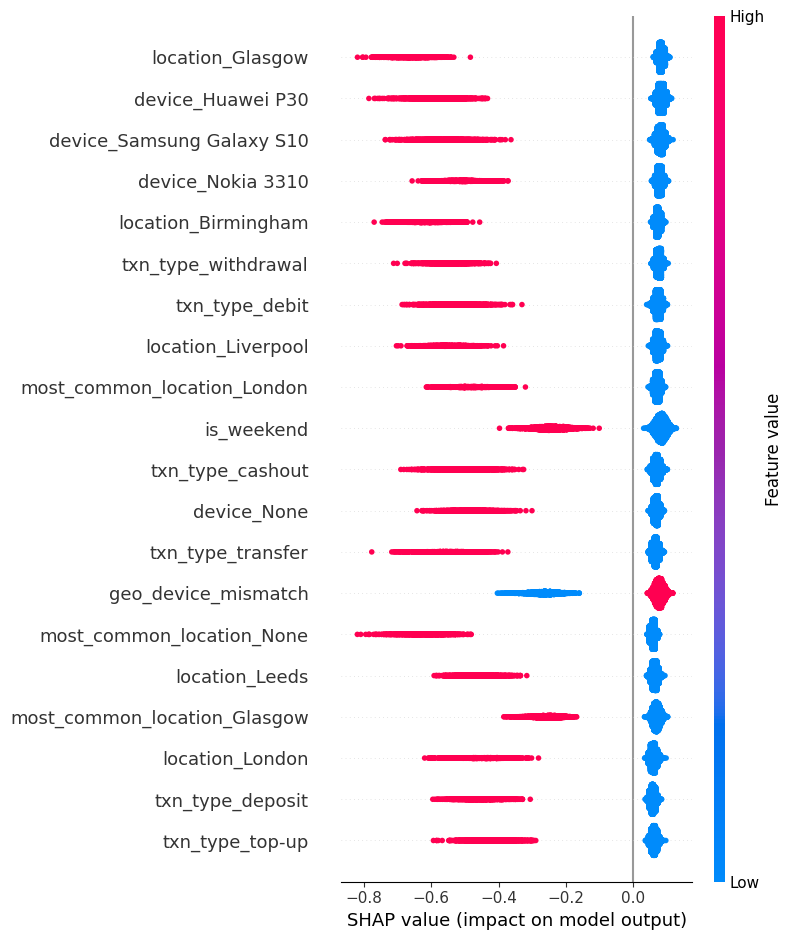

In [ ]:
import shap
explainer = shap.TreeExplainer(isf_model)
shap_values = explainer.shap_values(X_scaled_df)

# Summary plot
shap.summary_plot(shap_values, X_scaled_df)

This SHAP (SHapley Additive exPlanations) summary plot provides a powerful, interpretable view of a model's feature importance and impact. The vertical axis lists features ordered by their overall importance, while the horizontal axis shows the SHAP value, which represents the impact on the model's output. A positive SHAP value pushes the prediction higher, and a negative value pushes it lower. The color of each dot indicates the feature's original value (red for high, blue for low).

#### **1. Location & Device One-Hot Features Dominate**

The top five most impactful features are all location or device dummies:

1. location\_Glasgow
2. device\_Huawei P30
3. device\_Samsung Galaxy S10
4. device\_Nokia 3310
5. location\_Birmingham

* **High values** (red points) of these features lie to the left of zero, when a transaction is in Glasgow or is on one of those devices, the SHAP contribution is strongly negative, i.e. the model is less likely to flag it as anomalous.
* **Low values** (blue points) for these same features end up on the right when a transaction is *not* in Glasgow (or not on those devices), it leans toward anomaly.

The model has effectively learned “normal” locations (Glasgow, Birmingham) and “common” devices (Huawei P30, S10, Nokia 3310); everything else is relatively more suspicious.

#### **2. Transaction Type are less important**

txn\_type\_withdrawal, txn\_type\_debit, txn\_type\_cashout, txn\_type\_transfer all carry moderate weight.

 * Red (feature = 1) for these tends to push toward anomaly (points right of zero), meaning withdrawals, debits, cash-outs, and transfers are more often flagged.
 * By contrast txn\_type\_deposit and txn\_type\_top-up (near the bottom) are lighter and cluster closer to zero - these are largely considered benign.


#### **3. Geo-Device Mismatch Is a Strong Positive Driver**

The single geo\_device\_mismatch point (red) sits well to the right of zero - whenever location and device both change simultaneously, it’s one of the strongest positive pushes toward your anomaly label.

#### **4. Weekend vs. Weekday**

is\_weekend shows up in the middle:

  * High (1 = weekend, red) mostly lies to the right of zero which means that weekend transactions are somewhat more likely to be flagged.
  * Low (0 = weekday, blue) skews left which means that weekday activity is normal.


#### **Key Takeaways & Next Steps**

1. **Location/Device Bias**: The model’s notion of “normal” is heavily tied to a small set of cities and phones. If we deploy in a new region or with new devices, performance may suffer or we’ll see high false-positives.

2. **Anomaly Drivers**: True outliers tend to be withdrawals/transfers on unusual devices/locations, especially if they occur on the weekend or with a geo-device mismatch. Fraud investigations should prioritize that combination.

3. **Feature Engineering**: Since geo\_device\_mismatch is so predictive, we could break it into its own score or pump up its weight. Likewise, consider features for “new device but same location” vs. “new location but same device” could be explored to see which pattern is more suspicious.

4. **Model Reliability**: Because device/location one-hots dominate, model drift is a risk if the user base changes. Regular retraining or more robust encodings (e.g. count encoding, embeddings) would help maintain stability.


In [ ]:
def explain_anomaly_naturally(instance, shap_vals, feature_names, top_n=3, X_original=None):
    """
    Explains the top contributing features for a single anomalous transaction
    in a natural language format using SHAP values.

    Args:
        instance (pd.Series): The row of the original DataFrame for the anomalous transaction.
        shap_vals (np.ndarray): The SHAP values for the corresponding row in the scaled data.
        feature_names (pd.Index): The names of the features in the scaled data used for SHAP.
        top_n (int): The number of top contributing features to include in the explanation.
        X_original (pd.DataFrame): The original DataFrame with non-encoded features for reverse mapping.

    Returns:
        str: A natural language explanation of the anomaly.
    """
    feature_contributions = []
    instance_values = X_scaled_df.loc[instance.name, feature_names].values

    for feature, shap_val, instance_value in zip(feature_names, shap_vals, instance_values):
        feature_contributions.append((feature, shap_val, instance_value))

    top_features = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)[:top_n]

    reasons = []
    for feature, shap_val, value in top_features:
        direction = "increased" if shap_val > 0 else "decreased"
        clean_feature_name = feature.replace('_', ' ').capitalize()

        if feature.startswith('location'):
            original_location = feature.replace('location_', '').capitalize()  # Extract the location from the feature name
            reason = f"the transaction occurred in {original_location}, which {direction} the anomaly score"
        elif feature.startswith('most_common_location'):
            original_location = feature.replace('most_common_location_', '').capitalize()  # Extract the location from the feature name
            reason = f"the user typically transacts in {original_location}, which {direction} the score"
        elif feature.startswith('txn_type'):
            txn_type = feature.replace('txn_type_', '').replace('_', ' ').capitalize()
            reason = f"the transaction was a {txn_type}, which {direction} the score"
        else:
            formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else str(value)
            reason = f"{clean_feature_name} = {formatted_value} {direction} the anomaly score"

        reasons.append(reason)

    # Combine all reasons into one sentence
    return "This transaction was flagged as anomalous because: " + "; ".join(reasons) + "."


In [ ]:
# Select an instance to explain (e.g., the first anomaly from the intersection)
instance_to_explain = anomalies_intersection.iloc[0]
instance_index = instance_to_explain.name
shap_vals_to_explain = shap_values[X_scaled_df.index.get_loc(instance_index)]

# Get the feature names used for SHAP
feature_names = X_scaled_df.columns

# Generate the natural language explanation
explanation = explain_anomaly_naturally(instance_to_explain, shap_vals_to_explain, feature_names, X_original=df)

# Print the explanation
print(explanation)

This transaction was flagged as anomalous because: the transaction occurred in Glasgow, which decreased the anomaly score; the user typically transacts in Cardiff, which decreased the score; the transaction was a Transfer, which decreased the score.


In [ ]:
import umap
from sklearn.manifold import TSNE

In [ ]:
# UMAP Embedding
umap_emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

# t-SNE Embedding
tsne_emb = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled)

# Add labels for visualization
embedding_df = pd.DataFrame({
    'umap_1': umap_emb[:, 0],
    'umap_2': umap_emb[:, 1],
    'tsne_1': tsne_emb[:, 0],
    'tsne_2': tsne_emb[:, 1],
    'label': anomaly_labels
})

embedding_df['label'] = embedding_df['label'].map({1: 'Normal', -1: 'Anomaly'})

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


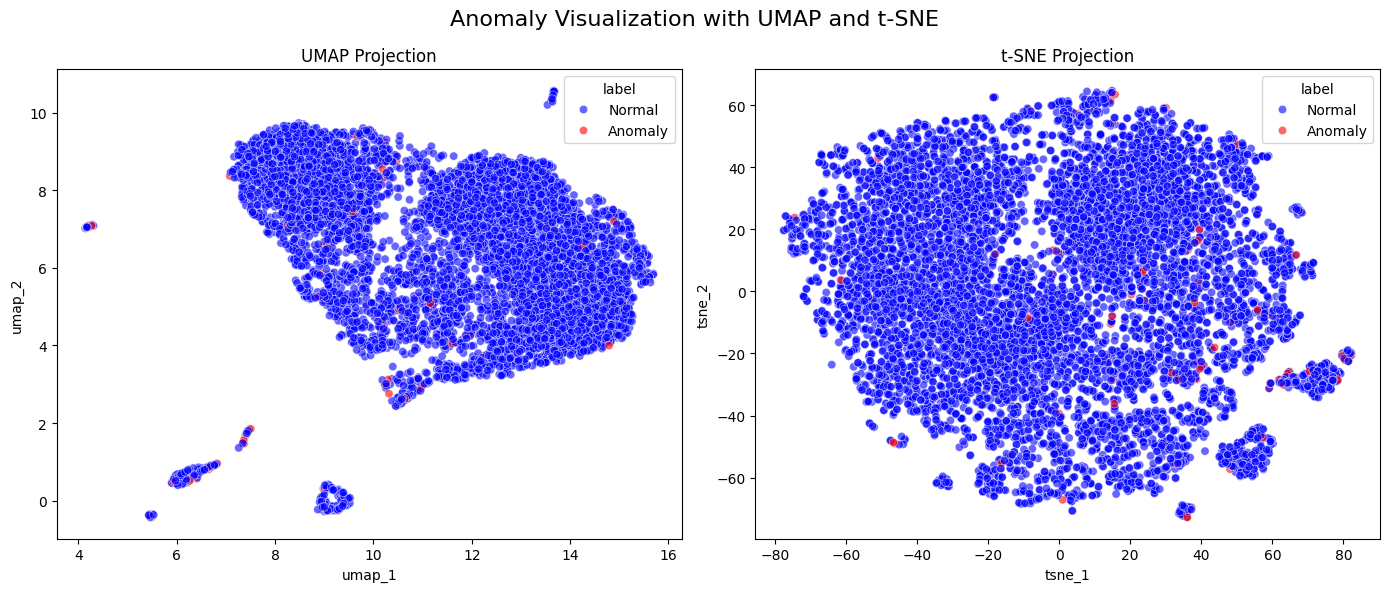

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# UMAP plot
sns.scatterplot(
    data=embedding_df,
    x='umap_1', y='umap_2',
    hue='label',
    palette={'Normal': 'blue', 'Anomaly': 'red'},
    alpha=0.6,
    ax=axs[0]
)
axs[0].set_title('UMAP Projection')

# t-SNE plot
sns.scatterplot(
    data=embedding_df,
    x='tsne_1', y='tsne_2',
    hue='label',
    palette={'Normal': 'blue', 'Anomaly': 'red'},
    alpha=0.6,
    ax=axs[1]
)
axs[1].set_title('t-SNE Projection')

plt.suptitle("Anomaly Visualization with UMAP and t-SNE", fontsize=16)
plt.tight_layout()
plt.show()


This two-panel plot visualizes a dataset that includes both normal and anomalous data points, projected into two dimensions using UMAP and t-SNE.

### **UMAP Projection**
The plot on the left uses UMAP (Uniform Manifold Approximation and Projection), a non-linear dimensionality reduction technique.  The UMAP plot shows the "normal" data (blue dots) forming several large, dense, and interconnected clusters. This suggests that the normal data points have a complex but well-defined underlying structure.

The anomalous points (red dots) are scattered in a few key locations:
  * Some anomalies form small, distinct, and isolated clusters away from the main body of normal data (e.g., the cluster near `umap_1`=4, `umap_2`=7, and the small clusters near the bottom left).
  * Other anomalies are found on the periphery or edges of the large clusters of normal data.

The UMAP visualization effectively separates the anomalies from the normal data. The existence of anomalies in isolated clusters suggests they are fundamentally different from normal data, while those on the edges might represent points that are "less normal" but still somewhat related to the main data.

### **t-SNE Projection**
t-SNE (t-Distributed Stochastic Neighbor Embedding) is used for dimensionality reduction.
The t-SNE plot also shows the normal data (blue dots) as a large, continuous cloud of points, with some sub-clusters visible within the main body.
The anomalous transactions (red dots) are distributed throughout the plot, but their pattern is different from the UMAP plot. How?
 * Anomalies are primarily located on the outer edges and periphery of the large central cluster of normal data points.   
 * They do not appear to form clear, isolated clusters as they do in the UMAP plot. Instead, they are more interspersed among the normal data, particularly where the density of normal points is lower.

The t-SNE plot confirms that anomalies are generally located in regions of low data density or on the fringes of the main data clusters. This supports the idea that anomalies are outliers, but unlike the UMAP plot, t-SNE doesn't clearly reveal distinct, isolated groups of anomalies. This difference highlights how the two techniques emphasize different aspects of data structure; UMAP seems better at preserving the isolated nature of certain anomaly types, while t-SNE emphasizes their outlier status relative to the main data mass.

#### Overall Insights and Conclusion
1.  **Anomaly Detection is Successful:** Both plots visually confirm that the anomaly detection method has worked effectively. The identified anomalies are not randomly distributed among the normal data points but are instead located in regions of low density or completely separate from the main data clusters.
2.  **Technique Comparison:** The choice of visualization technique matters. The UMAP plot provides a clearer picture of distinct anomaly groups by showing them as separated clusters, which could suggest multiple root causes for the anomalies. The t-SNE plot, while also showing the anomalies on the periphery, presents them more as a general class of outliers rather than distinct sub-groups.


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


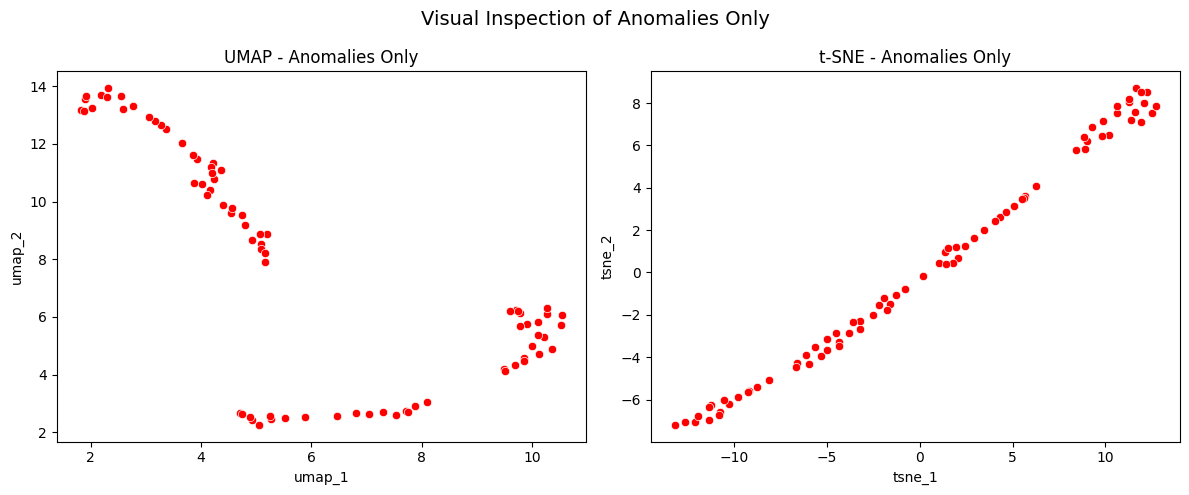

In [ ]:
# UMAP and t-SNE on anomalies_only
anomalies_only_numeric = anomalies_only.select_dtypes(include=np.number)
umap_emb_anom = umap.UMAP(random_state=42).fit_transform(anomalies_only_numeric)
tsne_emb_anom = TSNE(n_components=2, random_state=42, perplexity=15).fit_transform(anomalies_only_numeric)

anom_emb_df = pd.DataFrame({
    'umap_1': umap_emb_anom[:, 0],
    'umap_2': umap_emb_anom[:, 1],
    'tsne_1': tsne_emb_anom[:, 0],
    'tsne_2': tsne_emb_anom[:, 1]
})

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=anom_emb_df, x='umap_1', y='umap_2', color='red', ax=axs[0])
axs[0].set_title('UMAP - Anomalies Only')

sns.scatterplot(data=anom_emb_df, x='tsne_1', y='tsne_2', color='red', ax=axs[1])
axs[1].set_title('t-SNE - Anomalies Only')

plt.suptitle("Visual Inspection of Anomalies Only", fontsize=14)
plt.tight_layout()
plt.show()

Here is a breakdown of the analysis and insights:

#### **UMAP - Anomalies Only**
The data points are not a single, continuous cluster. Instead, they form two distinct clusters or manifolds. The first cluster is a dense, somewhat curved structure located roughly between `umap_1` values of 2 and 5, and `umap_2` values of 8 and 14, while the second cluster is a more spread-out, linear structure located roughly between `umap_1` values of 8 and 10, and `umap_2` values of 4 and 6.

The UMAP plot suggests that the anomalies do not all belong to a single type or group. There appear to be at least two distinct types of anomalies, as evidenced by the two separate clusters. This indicates that the underlying reasons for these anomalies might be different.

#### **t-SNE - Anomalies Only**
. t-SNE is particularly good at visualizing clusters and preserving local structure, but it often distorts global distances. The data points form a single, elongated, and somewhat disjointed structure that looks like a bent line - There is a clear main body of points that follows a roughly linear path from the bottom-left (`tsne_1` around -12, `tsne_2` around -3) up to the top-right, and also a clear separation or "jump" in the line, with a separate cluster of points at the top-right of the plot (`tsne_1` around 10, `tsne_2` around 6 to 9).

The t-SNE plot also suggests that there is more than one type of anomaly, or at least a significant distinction between them. The main linear structure could represent a type of anomaly that varies along a single dimension, while the separate cluster in the top-right represents a different, distinct type of anomaly.

### Overall Insights and Analysis
1.  **Multiple Anomaly Types:** Both UMAP and t-SNE, despite their different ways of projecting data, agree that the anomalies are not a single homogenous group. This is the most crucial insight. They seem to belong to at least two distinct categories.
2.  **Structural Differences:** The two techniques represent the structure differently. UMAP shows two well-separated clusters, which could be interpreted as two different "families" of anomalies. t-SNE shows an elongated, linear structure with a separate, denser cluster, which might suggest one common type of anomaly with a significant sub-type.

We can also visualize clusters from the DBSCAN model

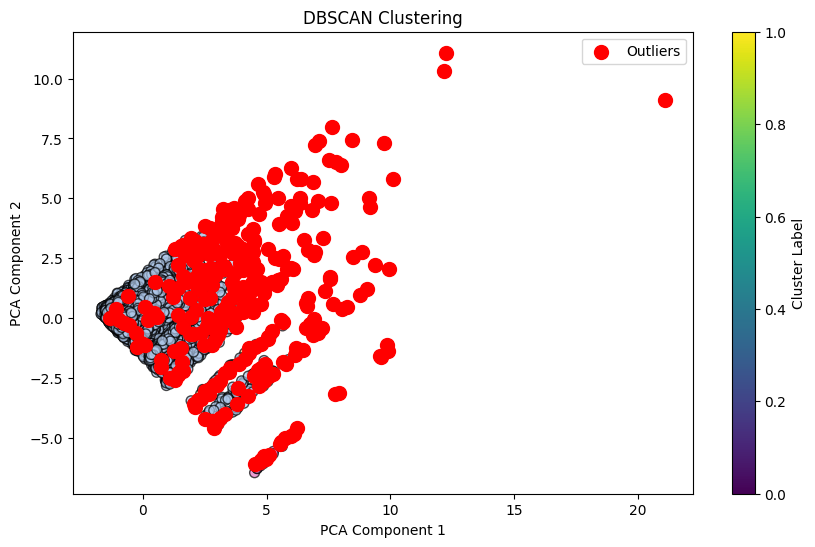

In [ ]:
from sklearn.decomposition import PCA

def visualize_dbscan_clusters(X_scaled, dbscan_labels):
    """
    Visualizes the DBSCAN clusters using a 2D scatter plot.

    Args:
        X_scaled (pd.DataFrame): The scaled feature matrix.
        dbscan_labels (np.ndarray): The labels assigned by DBSCAN (-1 for outliers).
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab20', s=50, alpha=0.7, edgecolors='k')

    plt.scatter(X_pca[dbscan_labels == -1, 0], X_pca[dbscan_labels == -1, 1], c='red', s=100, label='Outliers')

    plt.title("DBSCAN Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label='Cluster Label')
    plt.legend(loc='best')
    plt.show()

visualize_dbscan_clusters(X_scaled, dbscan_labels)


This does not look good. DBSCAN was probably not the best for this task.

## Data Dictionary

| Feature                       | Data Type      | Description                                                                     |
| :---------------------------- | :------------- | :------------------------------------------------------------------------------ |
| `timestamp`                   | `datetime64[ns]` | Timestamp of the transaction.                                                   |
| `user_id`                     | `object`       | Unique identifier for the user.                                                 |
| `txn_amount`                  | `float64`      | The amount of the transaction.                                                  |
| `txn_type`                    | `object`       | The type of transaction (e.g., cashout, debit, deposit).                        |
| `location`                    | `object`       | The location where the transaction occurred. Missing values were filled with "None". |
| `device`                      | `object`       | The device used for the transaction. Missing values were filled with "None".      |
| `avg_user_transaction_amount` | `float64`      | The average transaction amount for each user.                                   |
| `std_user_transaction_amount` | `float64`      | The standard deviation of transaction amounts for each user.                    |
| `user_max_transaction_amount` | `float64`      | The maximum transaction amount for each user.                                   |
| `transaction_type_entropy`    | `float64`      | The entropy of transaction types for each user (measure of diversity).          |
| `hour_of_day_sin`             | `float64`      | Sin transformation of the hour of the day.                                      |
| `hour_of_day_cos`             | `float64`      | Cos transformation of the hour of the day.                                      |
| `day_of_week`                 | `int32`        | The day of the week of the transaction (0=Monday, 6=Sunday).                  |
| `is_weekend`                  | `int64`        | Binary indicator: 1 if the transaction is on a weekend, 0 otherwise.            |
| `is_night`                    | `int64`        | Binary indicator: 1 if the transaction is during nighttime hours, 0 otherwise. |
| `time_since_last_txn`         | `float64`      | Time in seconds since the user's last transaction.                              |
| `txn_count_24hr`              | `float64`      | Number of transactions by the user in the last 24 hours.                        |
| `is_new_location`             | `int64`        | Binary indicator: 1 if the location is different from the previous transaction, 0 otherwise. |
| `location_change_freq`        | `float64`      | Frequency of location changes for each user.                                    |
| `most_common_location`        | `object`       | The most common location for each user.                                         |
| `amount_zscore`               | `float64`      | Z-score of the transaction amount relative to the user's average.             |
| `amount_to_avg_ratio`         | `float64`      | Ratio of the transaction amount to the user's average transaction amount.       |
| `geo_device_mismatch`         | `int64`        | Binary indicator: 1 if location and device changed simultaneously, 0 otherwise. |
